In [1]:
import scanpy as sc
from scprocessing.Pipeline import Pipeline
from scprocessing.QC import QC
from scprocessing.Normalization import Normalization
from scprocessing.Integration import Integration
from scprocessing.metrics import jaccard, silhouette, davies, calinski

In [2]:
# paths
nsg_bus_1 = "/mnt/shared/nationwide/Counts/NSG_BUS_1/outs/filtered_feature_bc_matrix.h5"
nsg_bus_2 = "/mnt/shared/nationwide/Counts/NSG_BUS_2/outs/filtered_feature_bc_matrix.h5"
nsg_bus_3 = "/mnt/shared/nationwide/Counts/NSG_BUS_3/outs/filtered_feature_bc_matrix.h5"

nsg_ctl_1 = "/mnt/shared/nationwide/Counts/NSG_CNTL_1/outs/filtered_feature_bc_matrix.h5"
nsg_ctl_2 = "/mnt/shared/nationwide/Counts/NSG_CNTL_2/outs/filtered_feature_bc_matrix.h5"
nsg_ctl_3 = "/mnt/shared/nationwide/Counts/NSG_CNTL_3/outs/filtered_feature_bc_matrix.h5"

nsg_s_bus_1 = "/mnt/shared/nationwide/Counts/NSG_S_BUS_1/outs/filtered_feature_bc_matrix.h5"
nsg_s_bus_2 = "/mnt/shared/nationwide/Counts/NSG_S_BUS_2/outs/filtered_feature_bc_matrix.h5"
nsg_s_bus_3 = "/mnt/shared/nationwide/Counts/NSG_S_BUS_3/outs/filtered_feature_bc_matrix.h5"

nsg_s_ctl_1 = "/mnt/shared/nationwide/Counts/NSG_S_CNTL_1/outs/filtered_feature_bc_matrix.h5"
nsg_s_ctl_2 = "/mnt/shared/nationwide/Counts/NSG_S_CNTL_2/outs/filtered_feature_bc_matrix.h5"
nsg_s_ctl_3 = "/mnt/shared/nationwide/Counts/NSG_S_CNTL_3/outs/filtered_feature_bc_matrix.h5"

# Reading Datasets

In [3]:
# read data
nsg_bus_1_data = sc.read_10x_h5(nsg_bus_1)
nsg_bus_2_data = sc.read_10x_h5(nsg_bus_2)
nsg_bus_3_data = sc.read_10x_h5(nsg_bus_3)

# creating metadata
nsg_bus_1_data.obs["Trial"] = "1"
nsg_bus_2_data.obs["Trial"] = "2"
nsg_bus_3_data.obs["Trial"] = "3"

# making names unique
nsg_bus_1_data.var_names_make_unique()
nsg_bus_2_data.var_names_make_unique()
nsg_bus_3_data.var_names_make_unique()

nsg_bus_1_data.obs_names_make_unique()
nsg_bus_2_data.obs_names_make_unique()
nsg_bus_3_data.obs_names_make_unique()

/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: Use

In [4]:
nsg_ctl_1_data = sc.read_10x_h5(nsg_ctl_1)
nsg_ctl_2_data = sc.read_10x_h5(nsg_ctl_2)
nsg_ctl_3_data = sc.read_10x_h5(nsg_ctl_3)

nsg_ctl_1_data.obs["Trial"] = "1"
nsg_ctl_2_data.obs["Trial"] = "2"
nsg_ctl_3_data.obs["Trial"] = "3"

nsg_ctl_1_data.var_names_make_unique()
nsg_ctl_2_data.var_names_make_unique()
nsg_ctl_3_data.var_names_make_unique()

nsg_ctl_1_data.obs_names_make_unique()
nsg_ctl_2_data.obs_names_make_unique()
nsg_ctl_3_data.obs_names_make_unique()

/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: Use

In [5]:
nsg_s_bus_1_data = sc.read_10x_h5(nsg_s_bus_1)
nsg_s_bus_2_data = sc.read_10x_h5(nsg_s_bus_2)
nsg_s_bus_3_data = sc.read_10x_h5(nsg_s_bus_3)

nsg_s_bus_1_data.obs["Trial"] = "1"
nsg_s_bus_2_data.obs["Trial"] = "2"
nsg_s_bus_3_data.obs["Trial"] = "3"

nsg_s_bus_1_data.var_names_make_unique()
nsg_s_bus_2_data.var_names_make_unique()
nsg_s_bus_3_data.var_names_make_unique()

nsg_s_bus_1_data.obs_names_make_unique()
nsg_s_bus_2_data.obs_names_make_unique()
nsg_s_bus_3_data.obs_names_make_unique()

/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: Use

In [6]:
nsg_s_ctl_1_data = sc.read_10x_h5(nsg_ctl_1)
nsg_s_ctl_2_data = sc.read_10x_h5(nsg_ctl_2)
nsg_s_ctl_3_data = sc.read_10x_h5(nsg_ctl_3)

nsg_s_ctl_1_data.obs["Trial"] = "1"
nsg_s_ctl_2_data.obs["Trial"] = "2"
nsg_s_ctl_3_data.obs["Trial"] = "3"

nsg_s_ctl_1_data.var_names_make_unique()
nsg_s_ctl_2_data.var_names_make_unique()
nsg_s_ctl_3_data.var_names_make_unique()

nsg_s_ctl_1_data.obs_names_make_unique()
nsg_s_ctl_2_data.obs_names_make_unique()
nsg_s_ctl_3_data.obs_names_make_unique()

/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: Use

# Run Pipeline

In [7]:
preprocess = Pipeline()
preprocess.add_step(QC())
preprocess.add_step(Normalization())
preprocess.add_step(Integration(method="merge"))

Quality Control
Normalizing Datasets
Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/user/scRNAseq-benchmarking/scprocessing/Integration.py:41: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


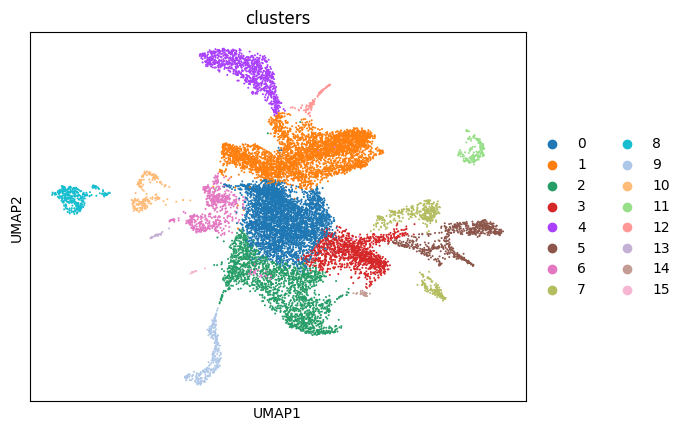

In [8]:
integrated = preprocess.execute([nsg_s_ctl_1_data, nsg_s_ctl_2_data, nsg_s_ctl_3_data])

# Metrics

In [9]:
jaccard(integrated, "clusters")

0.9995554765291608